In [1]:
from common.utility import show_implementation
from module.utility import plot_halfspace, print_table, make_vars
import numpy as np
import matplotlib.pyplot as plt

# Simplex method

Preamble: Though this chapter might dabble in some rather complicated linear algebra operations, it is rather simple once we learn about the [tableau method](#Tableau).

## Feasible direction
A **feasible direction** from some point $\mathbf x$ in a polyhedron $P$ is the vectors $\mathbf d$ such that $\mathbf x + \theta d \in P$ for some $\theta > 0$.
Geometrically, it means that we can move that that direction while staying in the polyhedron.

The simplex method is simply a way to move from one BFS to the next along some feasible direction, designed to reduce the objective $\mathbf c ^ T \mathbf x$.

Since $\mathbf A(\mathbf x + \theta \mathbf d ^ j) = \mathbf b$ and $\mathbf {Ax} = \mathbf b$ implies that  $\mathbf{Ad}^j = \mathbf 0$, we formulate the below: 

Let $B$ be the basis for $\mathbf x$.
For some nonbasic index $j \in N$, let $\mathbf d^j = (\mathbf d ^ j _ B, \mathbf d ^ j_N) ^T$ such that 
* $\mathbf{Ad}^j = \mathbf 0$
* $d_j^j = 1$
* $d_i^j = 0$ for $i \in N \setminus \{j \}$

We assert that $\mathbf{d}^j_B = -\mathbf{B}^{-1}\mathbf{A}_j$

Hence, $d^j$ is in the form of $(-\mathbf B^{-1} \mathbf A_j, 0, \dots ,0, 1, 0, \dots, 0)$ where the $1$ is in the $j$-th position.

Now, we just need to find a $\theta$ such that  $\mathbf x + \theta \mathbf d ^j \geq 0$.
We simply choose the largest possible $\theta$ while maintaining the inequality, which we claim is the below:
$$
\bar \theta _j = \min \{ \frac{(\mathbf B^{-1} \mathbf b)_i}{(\mathbf B^{-1} \mathbf A_j)_i}| i \in B, (\mathbf B^{-1} \mathbf A_j) _i > 0\}
$$

Note that if $\mathbf B^{-1} \mathbf A_j \leq 0$, then $\mathbf x + \theta \mathbf d ^j \geq 0$ for all $\theta \geq 0$, *ie* the feasible set is unbounded.

<span hidden> TODO: add proof </span>

### Reduced cost
We split the cost function into $\mathbf c = (\mathbf c_B, \mathbf c_N)$, basic and nonbasic.

The reduced cost $\bar c_j$ of a variable $x_j$ is defined as:
$$
\bar c_j = \mathbf c^T \mathbf d^j = c_j - \mathbf c^T_B \mathbf B^{-1} \mathbf A_j
$$

Notice that if $j \in B$, then $\bar c_j = 0$.

If $\bar c_j < 0$ and $\bar \theta_j > 0$, then:

$$
\mathbf c^T(\mathbf x + \bar \theta _j \mathbf d^j) 
= \mathbf c ^ \mathbf x + \bar \theta_j \mathbf c ^ T  \mathbf d ^ j
= \mathbf c  ^ T \mathbf x + \bar \theta_j \bar c_j
$$

Hence, the objective is improved by $\bar \theta _j \bar c_j$.

If $\bar c_j < 0$ and $\bar \theta_j = \infty$, then the problem is unbounded.

Instinctively, we can rationalize this value as the "maximum amount of cost we can obtain if we were to swap out some of our current resources to obtain 1 more unit of $j$".

We say that BFS is **non-degenerate** if $\mathbf x_B = \mathbf B ^{-1} \mathbf b > 0$

And equivalently, it is degenerate if some element of $\mathbf x_B$ is 0.

Since the non-basic variables have a value of $0$, a degenerate solution means that we have more $0$ than expected in our solution.

## Optimality condition
If $\mathbf B$ is associated with a BFS $\mathbf x$, and $\bar \mathbf c$ is the vector of reduced costs, then:
1. if $\bar{ \mathbf c} \geq 0$, then $\mathbf x$ is optimal
2. if $\mathbf x$ is optimal and non-degenerate, then $\bar {\mathbf c} \geq 0$

<span hidden> TODO: add proof </span>

Graphically, we can see why the reduced cost may not be 0 at an degenerate, optimal solution.

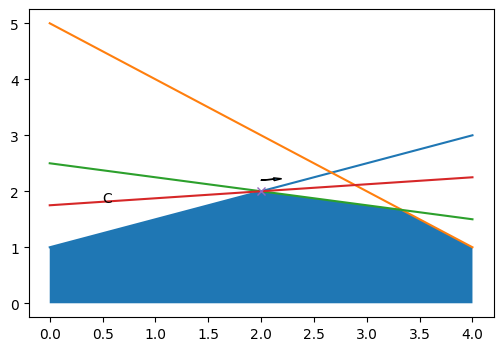

In [2]:
ax = plot_halfspace(
    np.linspace(0, 4),
    "  -1x1 + 2x2 = 2",
    "   2x1 + 2x2 = 10",
    " 0.5x1 + 2x2 = 5",
    "-0.5x1 + 4x2 = 7",
)
ax.plot(2, 2, "x")
ax.arrow(2, 2.2, 0.12, 0.015, head_width=0.05)
ax.annotate("C", (0.5, 1.8))
plt.show()

Notice that at $(2, 2)$ the solution is optimal (assuming $\mathbf c = (0, 1)$).
However, the constraint $C$ is not part of the basis, thus it thinks it is not active, and thus indicating that we can still travel along $C$ to increase our objective.
However, this is misguided as it did not account for the constraints placed by the basis.

And if we had computed the $\theta$ of that direction, we would see that $\theta = 0$, which means it is not a feasible direction.

## Simplex method
The simplex method is as follows:
1. Start with a basis $\mathbf B$ and its basic columns $\mathbf A _B$ and BFS $\mathbf x$
2. Compute the reduced costs $\bar c_j = c_j - \mathbf c ^ T _ B \mathbf B ^{-1} \mathbf A_j$ for all $j \in N$
    * if all $\bar c_j \geq 0$, then current BFS is optimal. Return the solution
    * Else, we choose some $j_*$ for which $\bar c _{j_*} < 0$. The corresponding variables $x_{j_*}$ is our **entering variable**
3. Compute $\mathbf u = \mathbf B^{-1} \mathbf A_{j_*}$
    * $\mathbf u \leq 0$ then the problem is unbounded and we can exit
    * Else, compute $\theta ^* = \min \frac{\mathbf X_B(i)}{u_i}$
4. Let $I$ be such that $\theta ^* = \min \frac{\mathbf X_B(I)}{u_I}$  
    * The corresponding $x_B(I)$ is the **leaving variable**
5. Form a new basis by replacing $\mathbf A_{B(I)}$ with $\mathbf A_j$
6. Repeat step 1 with the new basis

### Tableau 
The above algorithm seems rather complicated and long.
However, it is rather simple once we implement a tableau form.
All the matrix inversions and computations can be performed as row operations on the tableau.

We define the following simplex tableau

| Basic | $$x$$ | Solution |
| --- | --- | ---  |
| $$\mathbf {\bar c} $$ | $$\mathbf c ^ T - \mathbf c ^T _B \mathbf B^{-1} \mathbf A$$ | $$ - \mathbf c ^T _B \mathbf B^{-1} \mathbf b$$
| $$\mathbf x_B$$ | $$\mathbf B^{-1} \mathbf A$$ | $$\mathbf B^{-1} \mathbf b$$

Once again, it looks complicated, but if we consider the following standard form LP:

$$
\begin{alignedat}{10}
\min    -3 & x_1 - 2 & x_2 \quad &&&& \\
s.t. \quad & x_1 + 2 & x_2 +     &s_1&&& = 6 \\ 
         2 & x_1 +   & x_2 +     &&s_2&& = 8 \\ 
         - & x_1 +   & x_2 +     &&&s_3& = 1 \\ 
          &    & x_2 +     &&&&s_4 = 2 \\ 
          x_i, s_i \geq 0 \\
\end{alignedat}
$$

Our tableau would be:

|Basis| x1| x2| s1| s2| s3| s4| Solution | 
| --- |--- |--- |--- |--- |--- |--- |--- |
| $$\bar {\mathbf c}$$ | -3 | -2 | 0 | 0| 0| 0| 0|
| s1 | 1 | 2 | 1 | 0| 0| 0| 6|
| s2 | 2 | 1 | 0 | 1| 0| 0| 8|
| s3 | -1 | 1 | 0 | 0| 1| 0| 1|
| s4 | 0 | 1 | 0 | 0| 0| 1| 2|

In order words, we just simply read off the array in the system of linear equations.

The reason this works is because we set the basis as $\mathbf s$.
And the reduce cost $\bar {\mathbf c} = \mathbf c - \mathbf c^T_B \mathbf B ^{-1} \mathbf A = \mathbf c$ since $\mathbf c^T_B = \mathbf 0$ (cost function is not dependent on the slack variables).

Now, we will perform iterations on the tableau.

Firstly, we choose either $x_1$ or $x_2$ as the entering variable, since they are negative.
We chose $x_1$ in this case.

Then, we read down the $x_1$ column and find all the positive elements.
In this case, $1$ and $2$.
Then we compute the ratio of $b_i/v_i$, giving us $6/1 = 6$ and $8/2=4$ in this case.
Since 4 is the smaller of the 2, we will pick $s_2$ as the leaving variable.

We then multiply the $s_2$ row to make pivot $1$.

Our tableau would be:

|Basis| x1| x2| s1| s2| s3| s4| Solution | 
| --- |--- |--- |--- |--- |--- |--- |--- |
| $$\bar {\mathbf c}$$ | -3 | -2 | 0 | 0| 0| 0| 0|
| s1 | 1 | 2 | 1 | 0| 0| 0| 6|
| s2 | **1** | **1/2** | **0** | **1/2** | **0** | **0** | **4** |
| s3 | -1 | 1 | 0 | 0| 1| 0| 1|
| s4 | 0 | 1 | 0 | 0| 0| 1| 2|

Now we zero out all the other entries in the row to add $s_2$ into the basis.
Also, we update the label on the left to update our basis.

Our tableau would be:

|Basis| x1| x2| s1| s2| s3| s4| Solution | 
| --- |--- |--- |--- |--- |--- |--- |--- |
| $$\bar {\mathbf c}$$ | **0** | **-1/2** | **0** | **3/2**| **0**| **0**| **12**|
| s1 | **0** | **3/2** | **1** | **-1/2**| **0**| **0**| **2**|
| **x1** | 1 | 1/2 | 0 | 1/2| 0| 0| 4|
| s3 | **0** | **3/2** | **0** | **1/2**| **1**| **0**| **5**|
| s4 | 0 | 1 | 0 | 0| 0| 1| 2|

And this concludes one iteration of the simplex method.
We proceed until the first row is all non-negative.

To reiterate, the simplex method on a tableau is simply:
1. Choose any column with negative reduced cost
    * If all is positive, an optimal solution is found
2. Select all the rows in that column that contains positive values $v_i$
    * If entry is positive, then optimal solution is unbounded
3. Compute $b_i/v_i$ for the $v_i$ of each of the selected rows. Select the row with the smallest such value
4. Divide that row such that $v_i'$ is now $1$
5. Zero out all the columns along $v_i'$
6. Replace the basis label with the variable associated with $v_i$
7. Repeat step 1

#### Computing reduced cost

To obtain the reduced cost in general, we know that we can compute $\bar {\mathbf c} = \mathbf c - \mathbf c^T_B \mathbf B ^{-1} \mathbf A$.
We can substitute it as $\mathbf c - \mathbf p \mathbf A$, where $\mathbf p = \mathbf c^T_B \mathbf B ^{-1}$.

(Note: the $\mathbf p$ here has a special meaning, which we will discuss in [duality](./duality.ipynb))

The second piece of the puzzle is to notice that the reduced cost of the basis must be 0.

So, if we chose the identity matrix (or permutations of it), then it simply becomes finding the linear combination of $A$ such that all the reduced cost associated with the basic variables is 0.

For instance 

|Basis| x1| x2| x3 | x4 | x5 | Solution | 
| --- |--- |--- |--- |--- |--- |--- |
| $$\mathbf c$$ | 2| 0 | 3 | 0 | 1 | 0|
| C1| 2 | 1 | 1 | 0 | 0| 2 |
| C2 | 3 | 4 | 0 | -1 | 1| 12| 

In this case, we want to find $\mathbf p$ such that 
$$
\mathbf c - \mathbf p
\begin{pmatrix}
2 & 1 & 1 & 0 & 0 & 2\\
3 & 4 & 0 & -1 & 1 & 12
\end{pmatrix}
= (?, ?, 0, ?, 0, 0 )\\
\Rightarrow
\begin{pmatrix}
2 & 0 & 3 & 0 & 1 & 0\\
\end{pmatrix}
- p_1
\begin{pmatrix}
2 & 1 & 1 & 0 & 0 & 2\\
\end{pmatrix}
- p_2
\begin{pmatrix}
3 & 4 & 0 & -1 & 1 & 12
\end{pmatrix}
= (?, ?, 0, ?, 0, ?)\\
$$
This is if we view $p_i$ as the each value in the rows of $\mathbf p$.

Hence, it becomes obvious that $p_1 = 3$ and $p_2 = 1$.
Using this to evaluate the reduced cost, we get:

$$
\begin{pmatrix}
-7 & -7 & 0 & 1 & 0 & -18
\end{pmatrix}
$$

Even though this is the same as the formula variant, working with row operation is much easier for human computations.

In [3]:
from module.simplex import reduced_cost

costs = np.array([2, 0, 3, 0, 1, 0])
tableau = np.array(
    [
        [2, 1, 1, 0, 0, 2],
        [3, 4, 0, -1, 1, 12],
    ]
)

reduced_cost(costs, tableau, [2, 4])

array([ -7.,  -7.,   0.,   1.,   0., -18.])

#### Implementation

In [4]:
from module.simplex import simplex

show_implementation(simplex)

def simplex(c_bar, tableau, maxit=100):
    assert c_bar.shape[0] == tableau.shape[1]

    c_bar = c_bar + Fraction()
    tableau = tableau + Fraction()
    counter = 0
    while np.any(c_bar[:-1] < 0) and counter < maxit:
        col = c_bar[:-1].argmin()
        pivot_col = tableau[:, col]
        if np.all(pivot_col <= 0):
            raise ValueError("Unbounded objective")

        value = tableau[:, -1]
        metric = np.where(pivot_col > 0, value /
                          (pivot_col + (pivot_col == 0)), np.inf)
        row = metric.argmin()

        c_bar, tableau = pivot(c_bar, tableau, row,  col)
        counter += 1
    if counter == maxit:
        raise RuntimeError("Iterations exceeded")
    return c_bar, tableau


In [5]:
costs = np.array([-3, -2, 0, 0, 0, 0, 0])
tableau = np.array(
    [
        [1, 2, 1, 0, 0, 0, 6],
        [2, 1, 0, 1, 0, 0, 8],
        [-1, 1, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 2],
    ]
)
c_bar = reduced_cost(costs, tableau)

c_bar, new_tableau = simplex(c_bar, tableau)
print_table(c_bar, new_tableau, make_vars("x", 2) + make_vars("s", 4))

$$$$,$$x_1$$,$$x_2$$,$$s_1$$,$$s_2$$,$$s_3$$,$$s_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0.3333$$,$$ 1.3333$$,$$ 0$$,$$ 0$$,$$ 12.6667$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 0.6667$$,$$ -0.3333$$,$$ 0$$,$$ 0$$,$$ 1.3333$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ -0.3333$$,$$ 0.6667$$,$$ 0$$,$$ 0$$,$$ 3.3333$$
$$s_3$$,$$ 0$$,$$ 0$$,$$ -1$$,$$ 1$$,$$ 1$$,$$ 0$$,$$ 3$$
$$s_4$$,$$ 0$$,$$ 0$$,$$ -0.6667$$,$$ 0.3333$$,$$ 0$$,$$ 1$$,$$ 0.6667$$


#### Reading the solution

To read the solution off the tableau, first identify the basic variables.
These are the variables which coincides with the columns with only a single $1$, while the rest is $0$.
Then, the value of that variable in the solution is simply the value of the $b$ column, on the row where the $1$ reside.

Hence, in this case, the solution is $x_2=1.333, x_1=3.33, s_3=3, s_4=0.667$

Also, the top right value would be our negated objective value.
Usually, this value is unimportant and we don't need to keep track of it during manual computation, since we can derive it from the solution, like so $c = -3x_1 -2 x_2 = -3(\frac{10}{3})  -2 (\frac{4}{3}) = -\frac{28}{3}$.

Also, if our original basis is an identity matrix (in this case, it is since $s_1, s_2, s_3, s_4$ forms $\mathbf I$).
Then $\mathbf B^{-1}$ would manifest in the tableau in the same region after the simplex iterations.

In [6]:
print(new_tableau[:, :-1][-4:, -4:].astype("float64"))

[[ 0.66666667 -0.33333333  0.          0.        ]
 [-0.33333333  0.66666667  0.          0.        ]
 [-1.          1.          1.          0.        ]
 [-0.66666667  0.33333333  0.          1.        ]]


In [7]:
basis = [1, 0, 4, 5]
B = tableau[:, basis]
inv = np.linalg.inv(B)
inv.astype("float64")

array([[ 0.66666667, -0.33333333,  0.        ,  0.        ],
       [-0.33333333,  0.66666667,  0.        ,  0.        ],
       [-1.        ,  1.        ,  1.        ,  0.        ],
       [-0.66666667,  0.33333333,  0.        ,  1.        ]])

### Standard LP

Notice that in our previous discussions, our constraints are of the form 
$$
\mathbf{Ax} \leq \mathbf{b}\\
\mathbf {x} \geq \mathbf 0
$$

This means we were able to simply set $\mathbf x = \mathbf 0$ to obtain a BFS to start our algorithm.

However, if we were to consider standard form LP:

$$
\mathbf{Ax} = \mathbf{b}\\
\mathbf {x} \geq \mathbf 0
$$

We can no longer perform that since the constraints may not be satisfied.

#### 2-phase method

To resolve this, we perform the following:
1. Convert all constraints such that $\mathbf b \geq 0$ by multiplying by $-1$ if needed
2. Add a set of $y_i \in \mathbb R^m$ auxiliary variables to **constraints without positive slack**
3. Construct a new LP as per below

$$
\begin{align}
&\min &\sum y_i\\
&s.t. &\mathbf{Ax} = \mathbf{b}\\
&&\mathbf {x} \geq \mathbf 0 \\
&&\mathbf {y} \geq \mathbf 0
\end{align}
$$

4. Perform the simplex method, using $\mathbf y$ as the basis to obtain an initial BFS

The $\mathbf x$ in the solution of the above will be our BFS for our original LP.
The reason this works is because in the auxiliary LP, we are trying to drive down the value of the $y$ variables.
Hence, if a solution does exists, it will be populated with $x$ variables, while satisfying the constraints of the initial LP.

If the problem is infeasible, we would obtain a solution that contains a $y$ variable that is $>0$, and thus we can detect it at the first phase.

#### Example

Consider the below LP:
$$
\begin{alignedat}{20}
\min    \quad & 4x_1 & \quad + \quad &  & x_2 \quad  \\
s.t. \quad 3 & x_1 & \quad + \quad & x_2 & = 3 \\ 
           -4 & x_1 & \quad - \quad & 3x_2 & \leq -6 \\ 
         & x_1 & \quad + \quad & 2x_2 & \leq 4 \\ 
         & x_1, x_2 &&&\geq 0 \\
\end{alignedat}
$$

We perform steps 1-3 to obtain:

$$
\begin{alignedat}{20}
\min    \quad & & & & & & & & y_1 & + y_2\quad  \\
s.t. \quad 3 & x_1 & + & x_2 & & & & & +y_1 & &  = 3 \\ 
           4 & x_1 & + & 3x_2 & & -s_1& & & &+y_2 &= 6 \\ 
         & x_1 & + & 2x_2 & & & & +s_2 & & & = 4 \\ 
         & x_i,s_i,y_i &&& & & & & & &\geq 0 \\
\end{alignedat}
$$

In [8]:
costs = np.array([0, 0, 0, 0, 1, 1, 0])
tableau = np.array(
    [
        [3, 1, 0, 0, 1, 0, 3],
        [4, 3, -1, 0, 0, 1, 6],
        [1, 2, 0, 1, 0, 0, 4],
    ]
)

c_bar = reduced_cost(costs, tableau)

print_table(
    *simplex(c_bar, tableau), make_vars("x", 2) + make_vars("s", 2) + make_vars("y", 2)
)

$$$$,$$x_1$$,$$x_2$$,$$s_1$$,$$s_2$$,$$y_1$$,$$y_2$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 1$$,$$ 0$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ -0.2$$,$$ 0.4$$,$$ 0$$,$$ 0.4$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 0$$,$$ 0.6$$,$$ -0.2$$,$$ 0$$,$$ 1.8$$
$$s_1$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 1$$,$$ 1$$,$$ -1$$,$$ 1$$


After we perform our simplex method on the auxiliary array, notice that the $y$ variables are not in the basis, and thus we can drop its columns to obtain our basis for the original LP.

In [9]:
costs = np.array([4, 1, 0, 0, 0])
tableau = np.array(
    [
        [1, 0, 0.2, 0, 0.6],
        [0, 1, -0.6, 0, 1.2],
        [0, 0, 1, 1, 1],
    ]
)

c_bar = reduced_cost(costs, tableau)

print_table(*simplex(c_bar, tableau), make_vars("x", 2) + make_vars("s", 2))

$$$$,$$x_1$$,$$x_2$$,$$s_1$$,$$s_2$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 0.2$$,$$ -3.4$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ -0.2$$,$$ 0.4$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 0$$,$$ 0.6$$,$$ 1.8$$
$$s_1$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 1$$,$$ 1$$


##### Infeasible

Below is an system that is infeasible.

$$
\begin{alignedat}{20}
\min    \quad   & & & & &  & y \\
s.t. \quad 2  x_1 & + & x_2 & +s_1& &  & &   = 3 \\ 
           3  x_1 & + & 4x_2 & &  & -s_2 & +y &= 6 \\ 
         & x_i,s_i,y &&& & & & & & \geq 0 \\
\end{alignedat}
$$

In [10]:
costs = np.array([0, 0, 0, 0, 1, 0])
tableau = np.array(
    [
        [2, 1, 1, 0, 0, 2],
        [3, 4, 0, -1, 1, 12],
    ]
)

c_bar = reduced_cost(costs, tableau)

print_table(*simplex(c_bar, tableau), make_vars("x", 2) + make_vars("s", 2) + ["y"])

$$$$,$$x_1$$,$$x_2$$,$$s_1$$,$$s_2$$,$$y$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 5$$,$$ 0$$,$$ 4$$,$$ 1$$,$$ 0$$,$$ -4$$
$$x_2$$,$$ 2$$,$$ 1$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ 2$$
$$y$$,$$ -5$$,$$ 0$$,$$ -4$$,$$ -1$$,$$ 1$$,$$ 4$$


Notice that during our first phase, we obtain a solution where $y$ is still in the basis, thus the problem is infeasible.

#### Big-M Method

Similar to the 2-phase method, we construct the same auxiliary LP.
Except, we set the objective function to be
$$
\min \mathbf c ^T \mathbf x + M \sum y_i
$$
instead of $\sum y_i$.

Here, $M$ is treated as some arbitrarily large value.
Astute readers would realized that this is exactly the same motivation as the 2-phase method; trying to drive out the $y$ variables.

The benefit of this is this method can solve the original LP in 1 step.

In [11]:
# We fix some big constant M
# Mathematically, we simply keep M as a algebraic variable in our tableau
M = 100

costs = np.array([4, 1, 0, 0, M, M, 0])
tableau = np.array(
    [
        [3, 1, 0, 0, 1, 0, 3],
        [4, 3, -1, 0, 0, 1, 6],
        [1, 2, 0, 1, 0, 0, 4],
    ]
)

c_bar = reduced_cost(costs, tableau)
print_table(
    *simplex(c_bar, tableau),
    make_vars("x", 2) + make_vars("s", 2) + make_vars("y", 2),
    c=costs
)

$$$$,$$x_1$$,$$x_2$$,$$s_1$$,$$s_2$$,$$y_1$$,$$y_2$$,$$Solution$$
$$\mathbf c$$,$$ 4$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ 100$$,$$ 100$$,$$ 0$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 0.2$$,$$ 98.6$$,$$ 100$$,$$ -3.4$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ -0.2$$,$$ 0.4$$,$$ 0$$,$$ 0.4$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 0$$,$$ 0.6$$,$$ -0.2$$,$$ 0$$,$$ 1.8$$
$$s_1$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 1$$,$$ 1$$,$$ -1$$,$$ 1$$


And indeed, we obtain the same solution as before.

#### Dual Simplex method

Another way to solve general LP is to use the [dual simplex method](./duality.ipynb#Dual-Simplex-method)

### Special cases

#### Degeneracy


A BFS with some zero basic variables is degenerate.


In the simplex algorithm, degeneracy arises when there is a tie in the ratio test.
This means that when we zero out one of the rows, we will actually be zeroing out more than 1 rows instead.
This means some basic variable will be 0.

In [12]:
costs = np.array([-1, -3, 0, 0, 0])
tableau = np.array([[1, 4, 1, 0, 8], [1, 2, 0, 1, 4]])

c_bar = reduced_cost(costs, tableau)
print_table(*simplex(c_bar, tableau))

$$$$,$$x_1$$,$$x_2$$,$$x_3$$,$$x_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0.5$$,$$ 0.5$$,$$ 6$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 0.5$$,$$ -0.5$$,$$ 2$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ -1$$,$$ 2$$,$$ 0$$


In the simplex algorithm, degeneracy arises when there is a tie in the ratio test.
This means that when we zero out one of the rows, we will actually be zeroing out more than 1 rows instead.
This means some basic variable will be 0.

In this case, the degeneracy didn't cause us any issue, since the degenerate solution was optimal.

However, for the below case:

In [13]:
c_bar = np.array([-0.75, 20, -0.5, 6, 0, 0, 0, 0])
tableau = np.array(
    [
        [0.25, -8, -1, 9, 1, 0, 0, 0],
        [0.5, -12, -0.5, 3, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 0, 1, 1],
    ]
)

print_table(*simplex(c_bar, tableau))

RuntimeError: Iterations exceeded

Since degenerate solution can swap their variable with no change in cost, we run the risk of cycling between our degenerate solutions, as per above.
This happens when there is a cycle in the degenerate solutions, and none of them are optimal.
We implemented a simply cycle breaking algorithm, but a more sophisticated approach (such as Bland's anticycling rule) would be to keep track of the current pivots and explore new pivots every time, so we can still find the optimal solution even in this case.

### Alternative optima

If the LP has more than 1 optimal solution, then the below occurs:

In [14]:
c_bar = np.array([-2, -4, 0, 0, 0])
tableau = np.array([[1, 2, 1, 0, 10], [1, 1, 0, 1, 8]])
sol_costs, sol_tableau = simplex(c_bar, tableau)
print_table(sol_costs, sol_tableau)

$$$$,$$x_1$$,$$x_2$$,$$x_3$$,$$x_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 2$$,$$ 0$$,$$ 20$$
$$x_2$$,$$ 0.5$$,$$ 1$$,$$ 0.5$$,$$ 0$$,$$ 5$$
$$x_4$$,$$ 0.5$$,$$ 0$$,$$ -0.5$$,$$ 1$$,$$ 3$$


Our current solution is $x_2 = 5, x_4 = 3$.
Notice that we have a column (column 0) whose reduced cost is 0, is nonbasic, and contains positive values.
This means we can introduce it into the basis, while not changing the cost.
This indicates that there is more than 1 solution.

If we did, then the array would be

In [15]:
from module.simplex import pivot

print_table(*pivot(sol_costs, sol_tableau, 1, 0))

$$$$,$$x_1$$,$$x_2$$,$$x_3$$,$$x_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 2$$,$$ 0$$,$$ 20$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ 1$$,$$ -1$$,$$ 2$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ -1$$,$$ 2$$,$$ 6$$


Hence, we obtain another solution that is $x_1 = 6, x_2 = 2$.
In fact, any linear combination of these 2 solution forms the optimal set.

### Unbounded solution

If we find that the coefficient of any row is all non-positive, then we know that the solution space is unbounded in that direction.

And if the reduced cost of that column is negative, then the objective value is $-\infty$.

#### Unbounded objective value

In [16]:
c_bar = np.array([-2, -1, 0, 0, 0])
tableau = np.array([[-1, -1, 1, 0, 10], [2, 0, 0, 1, 40]])
print_table(*simplex(c_bar, tableau))

ValueError: Unbounded objective

Notice that column 2 has all non-positive values $(-1, 0)$ thus we can increase $x_2$ infinitely while keeping the constraint.
And since the reduced cost is also negative ($-1$), we can continually increase the objective value and thus the solution is unbounded.

#### Finite objective value

In [17]:
c_bar = np.array([-6.0, 2, 0, 0, 0])
tableau = np.array([[2, -1, 1, 0, 2], [1, 0, 0, 1, 4.0]])
print_table(*simplex(c_bar, tableau))

$$$$,$$x_1$$,$$x_2$$,$$x_3$$,$$x_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 2$$,$$ 2$$,$$ 12$$
$$x_1$$,$$ 1$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 4$$
$$x_2$$,$$ 0$$,$$ 1$$,$$ -1$$,$$ 2$$,$$ 6$$


Notice that this time, row 3 has also non-positive values $(0, -1)$ thus it is unbounded in that direction.
However, since the reduced cost is positive, that direction is not optimal, and thus we can obtain an optimal solution.

### Infeasibility

As discussed previously, infeasibility can be detected during the 2-phase method or the big-M method, when we obtain that our auxiliary solution contains some $y$.
If this occurs, we know that the problem is infeasible.

## Revisiting application

We will now revisit our [initial motivation](./introduction.ipynb#Application)

| Resource/Activity | Playing games | Studying | Eating | Napping | Amount available |
| --- | --- | --- | --- | --- | --- |
| Time | 2 | 1 | 0.5 | 1 | 8 |
| Energy | 2 | 1 | 0.5 | -3 | 4 |
| Hunger | 1 | 1 | -2 | 0.5 | 6 |
| Stress | -3 | 2 | 0 | -1 | 3 |
| Happiness | 2 | 1 | 0.5 | 0.5 | |

Since all the constraints are $\leq \mathbf b$, we simply introduce slack variables and use our simplex method.

Also, we negate our objective function, so rather than obtaining $\max Happiness$, we are obtaining $\min -Happiness$.

In [18]:
costs = np.array([-2, -1, -0.5, -0.5, 0, 0, 0, 0, 0])
tableau = np.array(
    [
        [2, 1, 0.5, 1, 1, 0, 0, 0, 8],
        [2, 1, 0.5, -3, 0, 1, 0, 0, 4],
        [1, 1, -2, 0.5, 0, 0, 1, 0, 6],
        [-3, 2, 0, -1, 0, 0, 0, 1, 3],
    ]
)
c_bar = reduced_cost(costs, tableau)
print_table(*simplex(c_bar, tableau), make_vars("x", 4) + make_vars("s", 4))

$$$$,$$x_1$$,$$x_2$$,$$x_3$$,$$x_4$$,$$s_1$$,$$s_2$$,$$s_3$$,$$s_4$$,$$Solution$$
$$\bar {\mathbf c}$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 0.875$$,$$ 0.125$$,$$ 0$$,$$ 0$$,$$ 7.5$$
$$x_4$$,$$ 0$$,$$ 0$$,$$ 0$$,$$ 1$$,$$ 0.25$$,$$ -0.25$$,$$ 0$$,$$ 0$$,$$ 1$$
$$x_1$$,$$ 1$$,$$ 0.5$$,$$ 0.25$$,$$ 0$$,$$ 0.375$$,$$ 0.125$$,$$ 0$$,$$ 0$$,$$ 3.5$$
$$s_3$$,$$ 0$$,$$ 0.5$$,$$ -2.25$$,$$ 0$$,$$ -0.5$$,$$ 0$$,$$ 1$$,$$ 0$$,$$ 2$$
$$s_4$$,$$ 0$$,$$ 3.5$$,$$ 0.75$$,$$ 0$$,$$ 1.375$$,$$ 0.125$$,$$ 0$$,$$ 1$$,$$ 14.5$$


From the solution, we see that $x_1=3.5$ and $x_4=1$, which means I should allocate 1 unit of napping, and 3.5 units of gaming; to maximize my happiness.